In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from measles import Utilities
Utilities.setPltDefaults({'font.size':14});

In [2]:
# read in population
tmp = r'C:\Users\krosenfeld\OneDrive - IDMOD\Data\Population\WorldBank'
pop_df = pd.read_csv(os.path.join(tmp,'API_SP.POP.TOTL_DS2_en_csv_v2_673119.csv'), header=2)

In [3]:
# read in incidence
tmp = r'C:\Users\krosenfeld\OneDrive - IDMOD\Data\Incidence\WHO'
inc_df = pd.read_excel(os.path.join(tmp,'incidence_series.xls'), sheet_name='Measles')
inc_df.head()

,WHO_REGION,ISO_code,Cname,Disease,2018,2017,2016,2015,2014,2013,...,1989,1988,1987,1986,1985,1984,1983,1982,1981,1980
0,EMR,AFG,Afghanistan,measles,2012.0,1511.0,638.0,1154.0,492.0,430.0,...,1170.0,4561.0,10357.0,8107.0,14457.0,16199.0,18808.0,20320.0,31107.0,32455.0
1,EUR,ALB,Albania,measles,1469.0,12.0,17.0,NaN,NaN,0.0,...,136034.0,0.0,0.0,0.0,0.0,0.0,17.0,3.0,NaN,NaN
2,AFR,DZA,Algeria,measles,3356.0,112.0,41.0,63.0,0.0,25.0,...,4169.0,2634.0,2500.0,3975.0,20114.0,22553.0,22126.0,29584.0,20849.0,15527.0
3,EUR,AND,Andorra,measles,0.0,0.0,0.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AFR,AGO,Angola,measles,57.0,29.0,53.0,119.0,11699.0,8523.0,...,19820.0,21009.0,13368.0,15580.0,22822.0,22685.0,22589.0,30067.0,19714.0,29656.0


# Functions

In [4]:
def w(n,s=3,dx=2):
    """Gaussian function for weighting """
    x = np.arange(-n,0) + dx - 1
    return 1/(s*np.sqrt(2*np.pi)) * np.exp(-0.5*(x+dx)**2/s**2)

In [5]:
def calc_mean_incidence(cases, pop, pop_norm = 100000, ny=10):
    # check that number of cases and population are the same size
    assert cases.size == pop.size    
    # number of samples (years
    nx = len(cases)
    # make sure the we have enough samples
    assert nx >= ny
    # initialize array
    mi = np.zeros(nx-ny+1)
    # loop through calculation
    weights = w(ny)
    for ix in range(len(mi)):
        mi[ix] = pop_norm * np.sum(weights * cases[ix:(ix+ny)] / pop[ix:(ix+ny)]) / np.sum(weights)
    return mi

In [6]:
def calc_lcv(cases, pop, ny=10, pop_norm = 100000):
    """Local CV"""
    nx = len(cases)
    # initialize
    wcv = np.zeros(nx-ny)
    # weights
    weights = np.ones(ny)
    for ix in range(len(wcv)):
        # data
        data = cases[ix:(ix+ny)] / pop[ix:(ix+ny)] * pop_norm
        # weighted mean incidence
        wmi = np.sum(weights * data) / np.sum(weights)
        # std
        num = np.sum(weights*(data - wmi)**2)
        nxp = np.sum(weights > 0)
        den = (nxp - 1) * np.sum(weights) / nxp
        # coefficient of variation is std / mean
        wcv[ix] = np.sqrt(num / den) / wmi
    return wcv

In [7]:
def calc_cv(cases, pop, ny=10, pop_norm =100000):
    """Weighted CV using LCV"""
    lcv = calc_lcv(cases, pop, ny=ny, pop_norm = pop_norm)
        
    cv = np.zeros(lcv.size)
    for ix in range(lcv.size):
        offset = np.min([ix+1, ny])
        weights = w(offset)
        cv[ix] = np.sum(weights*lcv[(ix-offset+1):ix+1])/np.sum(weights)
        
    return cv

In [8]:
def get_cases_pop(country,inc_df,pop_df):    
    Cname = country.capitalize()
    year = np.array([i for i in np.arange(1980,2019)])
    lind = inc_df.apply(lambda r: r['Cname'].startswith(Cname), axis=1)
    cases = np.array([inc_df[lind][str(y)].values[0] for y in year])
    pop = np.array([pop_df[pop_df['Country Name'] == Cname][str(y)].values[0] for y in year])
    return year, cases, pop

# Fig S1
mean incidence

In [9]:
# grab data
(year, cases, pop) =get_cases_pop('nigeria', inc_df, pop_df)

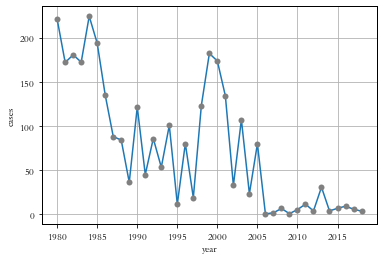

In [10]:
plt.plot(year,np.array(cases)/np.array(pop)*100000,'-o',markerfacecolor='gray', markeredgecolor='none')
plt.grid('on')
plt.ylabel('cases')
plt.xlabel('year')
xlim = plt.xlim()

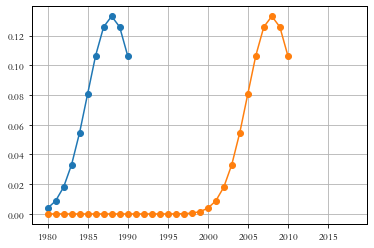

In [11]:
x = np.arange(1980,1991)
plt.plot(x,w(len(x)),'-o')
x = np.arange(1980,2011)
plt.plot(x,w(len(x)),'-o')
plt.xlim(xlim)
plt.grid('on')

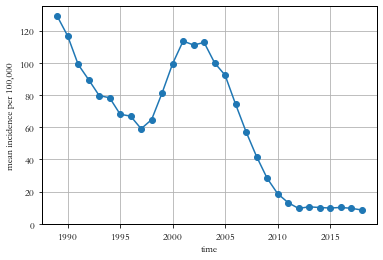

In [12]:
mean_incidence = calc_mean_incidence(cases,pop)
plt.plot(np.arange(1989,2019), mean_incidence, '-o')
plt.xlabel('time')
plt.ylabel('mean incidence per 100,000')
plt.ylim(bottom=0)
plt.grid('on')

# Fig S2
Coefficient of Variation (CV)

In [13]:
def calc_wcv(cases, pop, ny=10, pop_norm = 100000):
    """Weighted CV"""
    nx = len(cases)
    # initialize
    wcv = np.zeros(nx-ny)
    # weights
    weights = w(ny)
    for ix in range(len(wcv)):
        # data
        data = cases[ix:(ix+ny)] / pop[ix:(ix+ny)] * pop_norm
        # weighted mean incidence
        wmi = np.sum(weights * data) / np.sum(weights)
        # std
        num = np.sum(weights*(data - wmi)**2)
        nxp = np.sum(weights > 0)
        den = (nxp - 1) * np.sum(weights) / nxp
        # coefficient of variation is std / mean
        wcv[ix] = np.sqrt(num / den) / wmi
    return wcv

BOLIVIA


C:\Users\krosenfeld\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


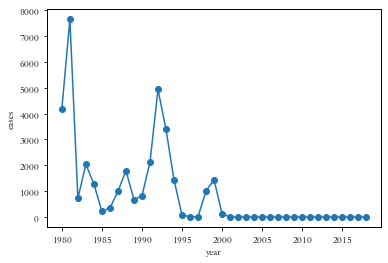

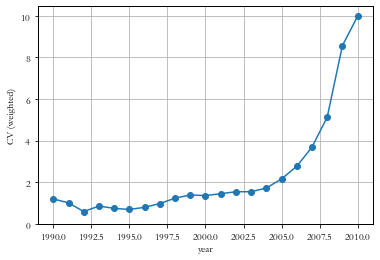

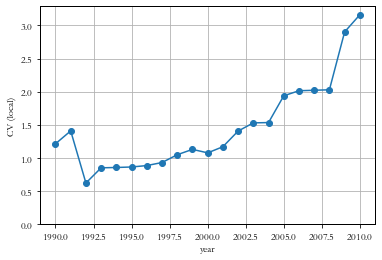

In [14]:
print('BOLIVIA')

(year, cases, pop) = get_cases_pop('bolivia', inc_df, pop_df)
plt.plot(year,cases,'-o')
plt.xlabel('year')
plt.ylabel('cases');
# Note that this data looks a bit different than theirs! We have zero cases past 2001

wcv = calc_wcv(cases,pop)
plt.figure()
plt.plot(np.arange(1990,2019), wcv,'-o')
plt.xlabel('year')
plt.ylabel('CV (weighted)')
plt.ylim(bottom=0)
plt.grid('on')

lcv = calc_lcv(cases,pop)
plt.figure()
plt.plot(np.arange(1990,2019), lcv,'-o')
plt.xlabel('year')
plt.ylabel('CV (local)')
plt.ylim(bottom=0)
plt.grid('on')

NIGERIA


(0.3, 1.5)

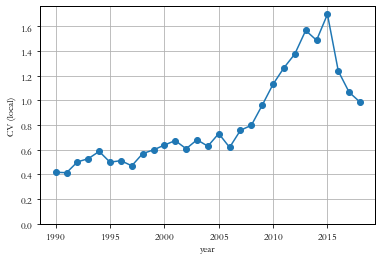

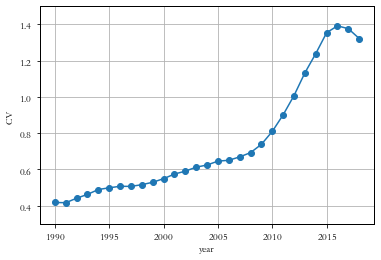

In [15]:
(year, cases, pop) = get_cases_pop('nigeria', inc_df, pop_df)

print('NIGERIA')

wcv = calc_lcv(cases,pop)
plt.figure()
plt.plot(np.arange(1990,2019), wcv,'-o')
plt.xlabel('year')
plt.ylabel('CV (local)')
plt.ylim(bottom=0)
plt.grid('on')

lcv = calc_cv(cases,pop)
plt.figure()
plt.plot(np.arange(1990,2019), lcv,'-o')
plt.xlabel('year')
plt.ylabel('CV ')
plt.grid('on')
plt.ylim([0.3, 1.5])
